### **Import Library:** 분석에 사용할 모듈 설치

In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm

# Model selection
from sklearn.model_selection import train_test_split

# for classification
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### **Data Loading:** 분석에 사용할 데이터 불러오기

In [16]:
df = pd.read_csv('./data/Titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


|     **변수**     |                           **설명**                          |
|:------------:|:-------------------------------------------------------:|
| **PassengerId**  |                        승객 번호                        |
|   **Survived**   |                 생존여부(1:생존, 0:사망)                |
|    **Pclass**    |           승선권 클래스(1:1st, 2:2nd, 3:3rd)            |
|     **Name**     |                        승객 이름                        |
|     **Sex**      |                        승객 성별                        |
|     **Age**      |                        승객 나이                        |
|    **SibSp**     |                동반한 형제자매, 배우자 수               |
|    **Patch**     |                   동반한 부모, 자식 수                  |
|    **Ticket**    |                     티켓의 고유 넘버                    |
|     **Fare**     |                       티켓의 요금                       |
|    **Cabin**     |                        객실 번호                        |
|   **Embarked**   | 승선한 항구명(C:Cherbourg, Q:Queenstown, S:Southampton) |

### **Preprocessing:** 데이터 정리 및 패턴 추출하기

In [17]:
# 결측값 처리
def fillnull(df):
    ## Age
    df_agem = df[df.Sex == 'male']
    df_agem = df_agem[['Age']].fillna(df_agem[['Age']].mean())

    df_agefm = df[df.Sex == 'female']
    df_agefm = df_agefm[['Age']].fillna(df_agefm[['Age']].mean())
    df[['Age']] = pd.concat([df_agem, df_agefm], axis=0).sort_index()

    ## Embarked
    df[['Embarked']] = df[['Embarked']].fillna(df['Embarked'].mode()[0], axis=0)

    ## Cabin
    df['Cabin'] = df['Cabin'].str.slice(0,1)
    df['Cabin'] = df['Cabin'].fillna('Temp')
    
    return df


# 데이터 정리
def prep(df):
    # Name
    name_sub = df['Name'].str.split(',', expand=True)[1]
    name_sub = name_sub.str.split('. ', expand=True)[0]
    name_sub.replace([' Mr'], 'Mr', inplace=True)
    name_sub.replace([' Mrs'], 'Mrs', inplace=True)
    name_sub.replace([' Ms', ' Miss'], 'Miss', inplace=True)
    name_sub.replace([' Don', ' Mme', ' Lady', 'Sir', 'Mlle', ' th', ' Jonkheer'], 'Noble', inplace=True)
    name_sub.replace([' Master', ' Major', ' Col', ' Capt', ' Sir', ' Mlle'], 'Officer', inplace=True)
    name_sub.replace([' Dr', ' Rev'], 'Priest', inplace=True)
    df['Name'] = name_sub.copy()

    # Ticket
    df['Ticket'] = df['Ticket'].str.replace('.','').str.replace('/','')
    df['Ticket'] = df['Ticket'].str.strip().str.split(' ').str[0]
    df.loc[df['Ticket'].str.isdigit(), 'Ticket'] = 'NUM'

    # Age
    age_interval = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    df['Age'] = np.digitize(df['Age'], bins=age_interval)
        
    return df


# 데이터 분리
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 데이터 변환
def label_encoding(X_train, X_test, colname, encoder):
    X_train_le = X_train.copy()
    X_test_le = X_test.copy()
    
    for i in colname: # 대상 변수들마다
        encoder = encoder.fit(X_train[i])

        for label in X_test[i].unique():
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)

        X_train_le[i] = encoder.transform(X_train[i])
        X_test_le[i] = encoder.transform(X_test[i])
        
    return X_train_le, X_test_le


def onehot_encoding(df, colname):
    df_ohe = df.copy()
    
    for i in colname:
        if i in df.columns:
            df_ohe = pd.get_dummies(df_ohe, columns=[i], drop_first=True)
            
    return df_ohe


# 데이터 변환 후 X_train과 X_test의 변수 갯수 일치
def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    # Train & Test 변수명 체크
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # 변수 갯수 일치
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
            X_te = X_te[X_tr.columns].copy()
            
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
            X_tr = X_tr[X_te.columns].copy()
            
    return X_tr, X_te


# 스케일 조정
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train),
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling

In [18]:
# 결측치 처리하기
df = fillnull(df)

# 데이터 범주화 하기
df = prep(df)

# 종속변수로 사용할 컬림 이름 선택하기
# 데이터를 X_train, X_test, Y_train, Y_test로 분리하기
Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

# ['Sex', 'Cabin', 'Ticket'] 변수들은 Label Encoding 하고,
# ['Name', 'Embarked'] 변수들은 Dummy Variable로 생성하기
label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)  

# 스케일 조정
scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

(712, 11) (712, 1)
(179, 11) (179, 1)


In [19]:
# 원데이터 확인
display(X_train, X_test, Y_train, Y_test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
329,330,1,Miss,female,1,0,1,NUM,57.98,B,C
749,750,3,Mr,male,3,0,0,NUM,7.75,Temp,Q
203,204,3,Mr,male,4,0,0,NUM,7.22,Temp,C
421,422,3,Mr,male,2,0,0,A5,7.73,Temp,Q
97,98,1,Mr,male,2,0,1,PC,63.36,D,C
...,...,...,...,...,...,...,...,...,...,...,...
98,99,2,Mrs,female,3,0,1,NUM,23.00,Temp,S
322,323,2,Miss,female,3,0,0,NUM,12.35,Temp,Q
382,383,3,Mr,male,3,0,0,STONO,7.92,Temp,S
365,366,3,Mr,male,3,0,0,C,7.25,Temp,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
172,173,3,Miss,female,0,1,1,NUM,11.13,Temp,S
524,525,3,Mr,male,3,0,0,NUM,7.23,Temp,C
452,453,1,Mr,male,3,0,0,NUM,27.75,C,C
170,171,1,Mr,male,6,0,0,NUM,33.50,B,S
620,621,3,Mr,male,2,1,0,NUM,14.45,Temp,C
...,...,...,...,...,...,...,...,...,...,...,...
388,389,3,Mr,male,3,0,0,NUM,7.73,Temp,Q
338,339,3,Mr,male,4,0,0,NUM,8.05,Temp,S
827,828,2,Officer,male,0,0,2,SCPARIS,37.00,Temp,C
773,774,3,Mr,male,3,0,0,NUM,7.22,Temp,C


,Survived
329,1
749,0
203,0
421,0
97,1
...,...
98,1
322,1
382,0
365,0


,Survived
172,1
524,0
452,0
170,0
620,0
...,...
388,0
338,1
827,1
773,0


In [20]:
# 전처리 완료 출력
display(X_train_fes, X_test_fes, Y_train, Y_test)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Mr,Name_Mrs,Name_Noble,Name_Officer,Name_Priest,Embarked_Q,Embarked_S
329,0.37,0.00,0.00,0.12,0.00,0.20,0.32,0.11,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00
749,0.84,1.00,1.00,0.38,0.00,0.00,0.32,0.02,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
203,0.23,1.00,1.00,0.50,0.00,0.00,0.32,0.01,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
421,0.47,1.00,1.00,0.25,0.00,0.00,0.04,0.02,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
97,0.11,0.00,1.00,0.25,0.00,0.20,0.36,0.12,0.38,1.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.11,0.50,0.00,0.38,0.00,0.20,0.32,0.04,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
322,0.36,0.50,0.00,0.38,0.00,0.00,0.32,0.02,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
382,0.43,1.00,1.00,0.38,0.00,0.00,0.86,0.02,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
365,0.41,1.00,1.00,0.38,0.00,0.00,0.11,0.01,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Mr,Name_Mrs,Name_Noble,Name_Officer,Name_Priest,Embarked_Q,Embarked_S
172,0.19,1.00,0.00,0.00,0.12,0.20,0.32,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
524,0.59,1.00,1.00,0.38,0.00,0.00,0.32,0.01,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
452,0.51,0.00,1.00,0.38,0.00,0.00,0.32,0.05,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.00
170,0.19,0.00,1.00,0.75,0.00,0.00,0.32,0.07,0.12,1.00,0.00,0.00,0.00,0.00,0.00,1.00
620,0.70,1.00,1.00,0.25,0.12,0.00,0.32,0.03,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,0.44,1.00,1.00,0.38,0.00,0.00,0.32,0.02,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
338,0.38,1.00,1.00,0.50,0.00,0.00,0.32,0.02,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
827,0.93,0.50,1.00,0.00,0.00,0.40,0.57,0.07,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
773,0.87,1.00,1.00,0.38,0.00,0.00,0.32,0.01,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


,Survived
329,1
749,0
203,0
421,0
97,1
...,...
98,1
322,1
382,0
365,0


,Survived
172,1
524,0
452,0
170,0
620,0
...,...
388,0
338,1
827,1
773,0


In [22]:
# 전처리 후 통계량 확인하기
display(X_train_fes.describe(), X_test_fes.describe(), Y_train.describe(), Y_test.describe())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Mr,Name_Mrs,Name_Noble,Name_Officer,Name_Priest,Embarked_Q,Embarked_S
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00
mean,0.50,0.66,0.65,0.32,0.06,0.07,0.35,0.06,0.85,0.59,0.13,0.01,0.05,0.01,0.09,0.73
std,0.29,0.41,0.48,0.17,0.14,0.15,0.16,0.10,0.30,0.49,0.34,0.07,0.21,0.11,0.29,0.45
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.50,0.00,0.25,0.00,0.00,0.32,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.50,1.00,1.00,0.38,0.00,0.00,0.32,0.03,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.74,1.00,1.00,0.38,0.12,0.00,0.32,0.06,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Name_Mr,Name_Mrs,Name_Noble,Name_Officer,Name_Priest,Embarked_Q,Embarked_S
count,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00,179.00
mean,0.51,0.62,0.65,0.31,0.07,0.09,0.34,0.06,0.81,0.55,0.17,0.01,0.08,0.03,0.06,0.72
std,0.30,0.43,0.48,0.18,0.13,0.19,0.15,0.07,0.33,0.50,0.37,0.07,0.27,0.17,0.23,0.45
min,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.00,0.00,0.25,0.00,0.00,0.32,0.02,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.51,1.00,1.00,0.25,0.00,0.00,0.32,0.04,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,0.77,1.00,1.00,0.38,0.12,0.20,0.32,0.07,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,0.75,0.62,1.20,1.07,0.48,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Survived
count,712.00
mean,0.39
std,0.49
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


,Survived
count,179.00
mean,0.36
std,0.48
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


### **Applying Base Algorithm:** Logistic Regression

In [24]:
# Logistic Regression
X_train_fes = sm.add_constant(X_train_fes)
X_test_fes = sm.add_constant(X_test_fes)

model_logitreg = sm.Logit(Y_train, X_train_fes).fit()
display(model_logitreg.summary())

# 계수 해석
print("Effect of X..")
model_logitreg_beta = pd.DataFrame(model_logitreg.params, columns=['coef'])
display(pd.concat([model_logitreg_beta, 
                   pd.DataFrame(np.exp(model_logitreg.params), columns=['odds'])],
                   axis=1))

# 예측
P_trpred = model_logitreg.predict(X_train_fes)
P_tepred = model_logitreg.predict(X_test_fes)

Optimization terminated successfully.
         Current function value: 0.414285
         Iterations 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.3801
Time:                        18:04:50   Log-Likelihood:                -294.97
converged:                       True   LL-Null:                       -475.84
Covariance Type:            nonrobust   LLR p-value:                 3.668e-67
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.7321      0.649      5.754      0.000       2.461       5.003
PassengerId     -0.0320      0.365     -0.088      0.930      -0.747       0.683
Pclass          -1.9552      0.409     -4.776      0.000      -2.758      -1.153
Sex           -167.8068        nan        nan        nan         nan         nan
Age             -2.4841      0.762     -3.262      0.001      -3.977      -0.991
SibSp           -4.1017      1.107     -3.705      0.000      -6.272      -1.932
Parch           -1.4440      0.766     -1.886      0.059      -2.945       0.057
Ticket           0.3358      0.669      0.502      0.616      -0.976       1.647
Fare             1.2815      1.345      0.953      0.341      -1.355       3.918
Cabin           -0.4171      0.508     -0.822      0.411      -1.412       0.578
Name_Mr        165.0221        nan        nan        nan         nan         nan
Name_Mrs         0.8312      0.383      2.169      0.030       0.080       1.582
Name_Noble      61.7478   3.46e+22   1.78e-21      1.000   -6.79e+22    6.79e+22
Name_Officer   168.1780        nan        nan        nan         nan         nan
Name_Priest    164.3788        nan        nan        nan         nan         nan
Embarked_Q       0.0129      0.436      0.030      0.976      -0.841       0.867
Embarked_S      -0.2858      0.282     -1.012      0.312      -0.839       0.268
================================================================================
"""

Effect of X..


,coef,odds
const,3.73,41.77
PassengerId,-0.03,0.97
Pclass,-1.96,0.14
Sex,-167.81,0.00
Age,-2.48,0.08
SibSp,-4.10,0.02
Parch,-1.44,0.24
Ticket,0.34,1.40
Fare,1.28,3.60
Cabin,-0.42,0.66


### **Evaluation:** 분석 성능 확인/평가하기

In [25]:
# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true, Y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['True: 0', 'True: 1'], 
                            columns=['Pred: 0', 'Pred: 1'])
    
    return conf_mat


# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5)):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


# Precision & Recall Curve 함수화
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()

Optimization terminated successfully.
         Current function value: 0.414285
         Iterations 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.3801
Time:                        18:16:03   Log-Likelihood:                -294.97
converged:                       True   LL-Null:                       -475.84
Covariance Type:            nonrobust   LLR p-value:                 3.668e-67
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.7321      0.649      5.754      0.000       2.461       5.003
PassengerId     -0.0320      0.365     -0.088      0.930      -0.747       0.683
Pclass          -1.9552      0.409     -4.776      0.000      -2.758      -1.153
Sex           -167.8068        nan        nan        nan         nan         nan
Age             -2.4841      0.762     -3.262      0.001      -3.977      -0.991
SibSp           -4.1017      1.107     -3.705      0.000      -6.272      -1.932
Parch           -1.4440      0.766     -1.886      0.059      -2.945       0.057
Ticket           0.3358      0.669      0.502      0.616      -0.976       1.647
Fare             1.2815      1.345      0.953      0.341      -1.355       3.918
Cabin           -0.4171      0.508     -0.822      0.411      -1.412       0.578
Name_Mr        165.0221        nan        nan        nan         nan         nan
Name_Mrs         0.8312      0.383      2.169      0.030       0.080       1.582
Name_Noble      61.7478   3.46e+22   1.78e-21      1.000   -6.79e+22    6.79e+22
Name_Officer   168.1780        nan        nan        nan         nan         nan
Name_Priest    164.3788        nan        nan        nan         nan         nan
Embarked_Q       0.0129      0.436      0.030      0.976      -0.841       0.867
Embarked_S      -0.2858      0.282     -1.012      0.312      -0.839       0.268
================================================================================
"""

Effect of X..


,coef,odds
const,3.73,41.77
PassengerId,-0.03,0.97
Pclass,-1.96,0.14
Sex,-167.81,0.00
Age,-2.48,0.08
SibSp,-4.10,0.02
Parch,-1.44,0.24
Ticket,0.34,1.40
Fare,1.28,3.60
Cabin,-0.42,0.66


Confusion Matrix: Train


,Pred: 0,Pred: 1
True: 0,380,55
True: 1,65,212


Confusion Matrix: Test


,Pred: 0,Pred: 1
True: 0,101,13
True: 1,14,51


Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.85      0.87      0.86       435
     class 1       0.79      0.77      0.78       277

    accuracy                           0.83       712
   macro avg       0.82      0.82      0.82       712
weighted avg       0.83      0.83      0.83       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.89      0.88       114
     class 1       0.80      0.78      0.79        65

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

ROC Curve: Train


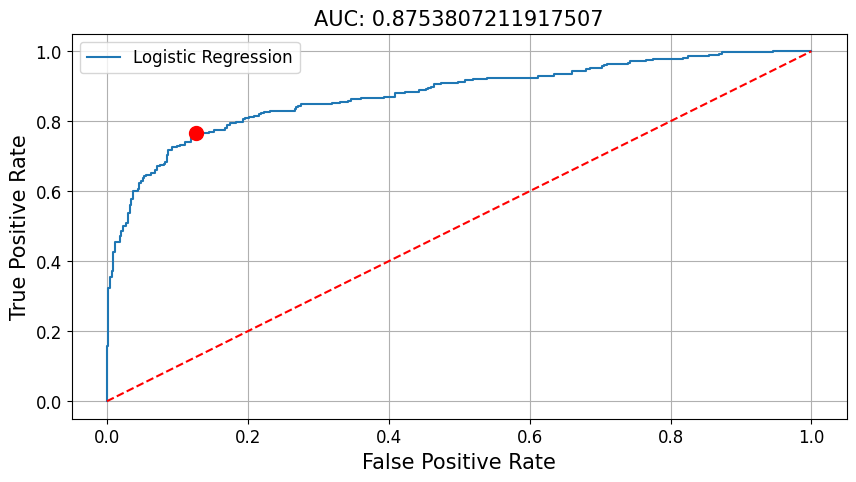

ROC Curve: Test


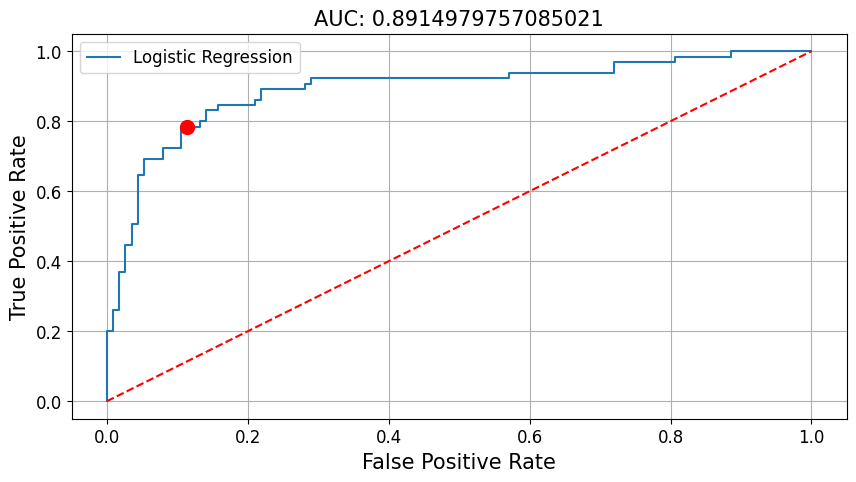

Precision-Recall Curve: Train


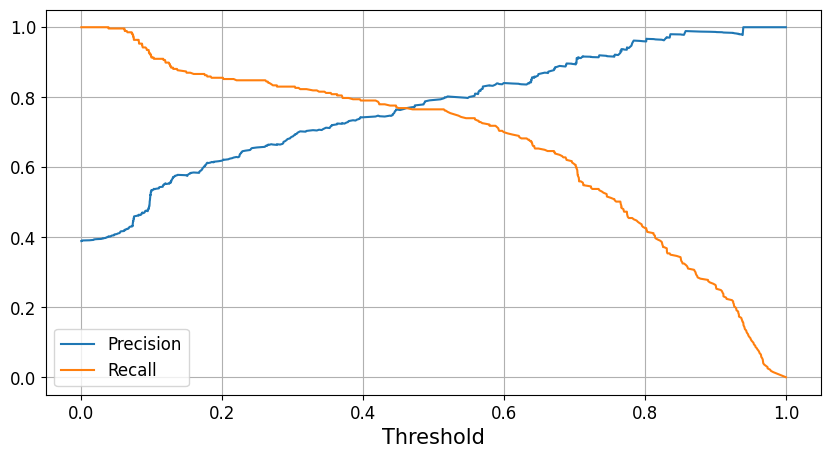

Precision-Recall Curve: Test


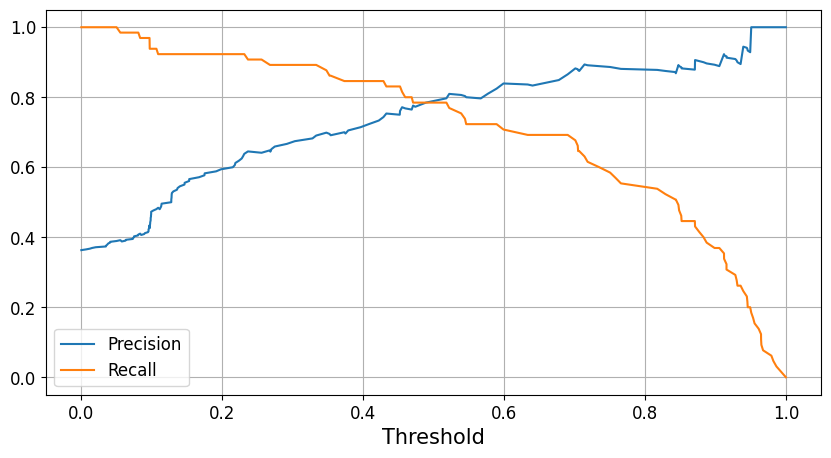

In [26]:
# Logistic Regression
X_train_fes = sm.add_constant(X_train_fes)
X_test_fes = sm.add_constant(X_test_fes)

model_logitreg = sm.Logit(Y_train, X_train_fes).fit()
display(model_logitreg.summary())

## 계수 해석
print("Effect of X..")
model_logitreg_beta = pd.DataFrame(model_logitreg.params, columns=['coef'])
display(pd.concat([model_logitreg_beta, 
                   pd.DataFrame(np.exp(model_logitreg.params), columns=['odds'])],
                   axis=1))

# 예측
P_trpred = model_logitreg.predict(X_train_fes)
P_tepred = model_logitreg.predict(X_test_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
display(evaluation_class_ConfusionMatrix(Y_train, P_trpred>=0.5))
print('Confusion Matrix: Test')
display(evaluation_class_ConfusionMatrix(Y_test, P_tepred>=0.5))

## Classification Report
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, P_trpred>=0.5)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, P_tepred>=0.5)

## ROC Curve & AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred)
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred)

## Precision & Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred)
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred)